In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune
# import hls4ml

In [23]:
batch = 1024
df = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/df.parquet')
X = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


# Original Model

In [25]:
layers = [64,32,16]

In [26]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2],1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

In [28]:
def train(model, train_loader, test_loader, lr, num_epochs, weight_decay):

    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop (test set)
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += loss.item()

        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))

    return train_losses, test_losses, model


In [31]:
def plot_loss(train_losses, test_losses, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training and testing loss
    ax.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
    ax.plot(test_losses, label='Testing Loss', color='orange', linewidth=1.5)

    # Set title and labels with appropriate font sizes
    ax.set_title(f"Loss Over Epochs -- {model_name}", fontsize=18, pad=20)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)

    # Add the subtitle if provided
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=10, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability and aesthetics
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()


In [29]:
model = BinaryClassificationModel()

In [30]:
# Train model
lr = 0.0005
num_epochs = 40
weight_decay = 1e-5
train_loss_1, test_loss_1, model_1 = train(model, train_loader, test_loader, lr, num_epochs, weight_decay)


Epochs: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


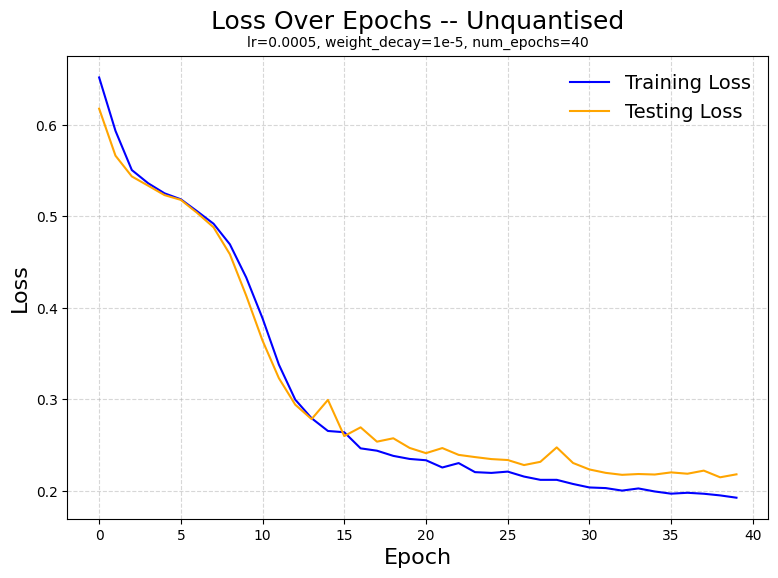

In [34]:
# plot the loss function
plot_loss(train_loss_1, test_loss_1, subtitle="lr=0.0005, weight_decay=1e-5, num_epochs=40", model_name="Unquantised")

In [41]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [42]:
AUC(model_1,test_loader)

AUC = 0.9668312741428415


In [48]:
import torch
import numpy as np
import time

def inference_time(model_qat, test_loader):

    model_qat.eval()
    T_qat = []
    y_pre = []
    for _ in range(200):
        with torch.no_grad():
            correct = 0
            total = 0
            times = 0
            for inputs, labels in test_loader:
                stt = time.time()
                outputs = model_qat(inputs)
                ent = time.time()
                times += ent - stt
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_pre.append(predicted)
            T_qat.append(times)

    T_qat = np.array(T_qat)
    
    accuracy = correct / total
    
    print(f'Accuracy: {accuracy}')
    print(f'Predict time: {times}')
    
    return T_qat, accuracy, times


In [49]:
# Accuracy and inference time
T_1, Acc_1, IT_1 = inference_time(model_1, test_loader)

Accuracy: 0.9174166666666667
Predict time: 0.005837678909301758


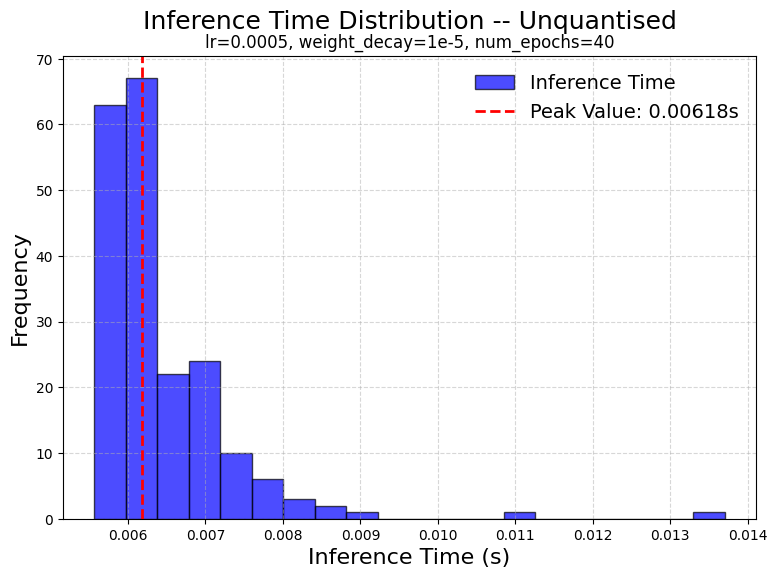

In [50]:
plot_time(T_1, subtitle="lr=0.0005, weight_decay=1e-5, num_epochs=40", model_name="Unquantised")

In [51]:

model_1.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs = model_1(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
    
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9174166666666667
Predict time: 0.0068798065185546875


In [46]:
def plot_time(T, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram
    n, bins, patches = ax.hist(T, bins=20, density=False, alpha=0.7, color='blue', edgecolor='black', label='Inference Time')

    # Find the peak value and its corresponding bin
    peak_value = np.mean(n)
    peak_index = np.argmax(n)
    peak_bin_center = (bins[peak_index] + bins[peak_index + 1]) / 2

    # Plot a vertical line at the peak value
    ax.axvline(x=peak_bin_center, color='red', linestyle='--', linewidth=2, label=f'Peak Value: {peak_bin_center:.5f}s')

    # Set title and labels with appropriate font sizes
    ax.set_title(f'Inference Time Distribution -- {model_name}', fontsize=18, pad=20)
    ax.set_xlabel('Inference Time (s)',fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)

    # Add the subtitle if provided, adjusting its position to avoid overlap
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=12, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()

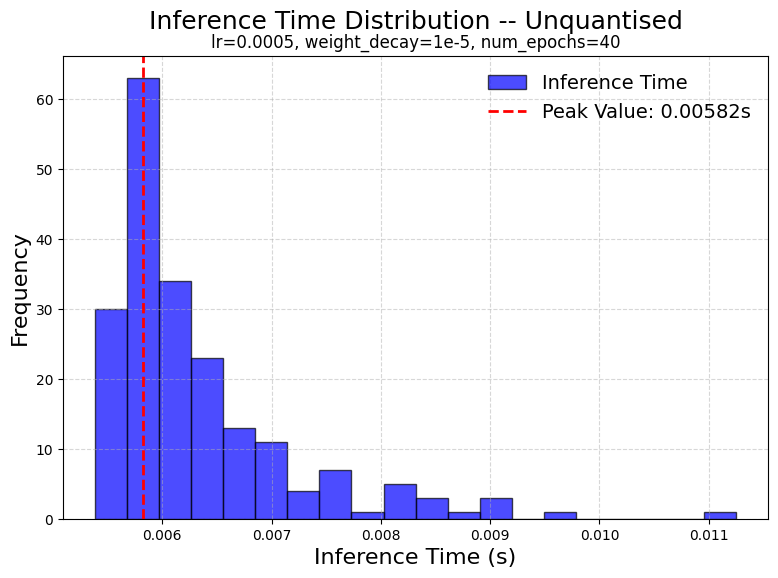

In [47]:
plot_time(T, subtitle="lr=0.0005, weight_decay=1e-5, num_epochs=40", model_name="Unquantised")

In [37]:
model = BinaryClassificationModel()

In [38]:
# Train model
lr = 0.0005
num_epochs = 40
weight_decay = 1e-3
train_loss_2, test_loss_2, model_2 = train(model, train_loader, test_loader, lr, num_epochs, weight_decay)


Epochs: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


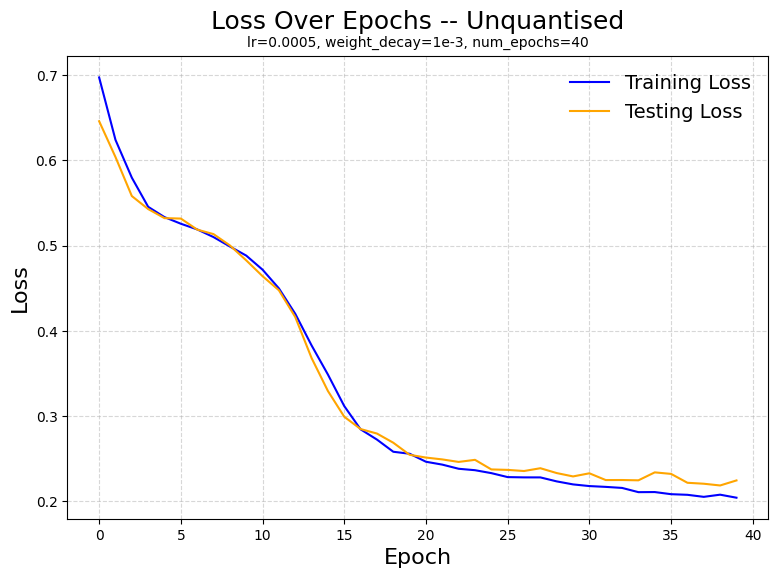

In [39]:
# plot the loss function
plot_loss(train_loss_2, test_loss_2, subtitle="lr=0.0005, weight_decay=1e-3, num_epochs=40", model_name="Unquantised")

In [43]:
AUC(model_2,test_loader)

AUC = 0.9637362850886264


In [15]:
model = BinaryClassificationModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        t.set_postfix(train_loss=loss.item())


100%|██████████| 40/40 [00:18<00:00,  2.19it/s, train_loss=0.203]


In [16]:
model.eval()
y_pre = []
T = []
times = 0
for _ in range(200):
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
    
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9155833333333333
Predict time: 1.4251832962036133


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

def train(model, lr, num_epochs, weight_decay):
    # Loss function
    criterion = nn.BCELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Track losses and start the timer
    train_losses = []
    test_losses = []
    start_time = time.time()
    
    # Training loop
    with tqdm(range(num_epochs), desc="Epochs") as epochs:
        for epoch in epochs:
            model.train()  # Set model to training mode
            running_loss = 0.0
            
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            # Average training loss for this epoch
            epoch_loss = running_loss / len(train_loader)
            train_losses.append(epoch_loss)
            epochs.set_postfix(train_loss=epoch_loss)
            
            # Evaluation phase
            model.eval()  # Set model to evaluation mode
            test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)
                    test_loss += loss.item()
            
            # Average test loss for this epoch
            test_epoch_loss = test_loss / len(test_loader)
            test_losses.append(test_epoch_loss)
    
    # Time taken
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    
    return train_losses, test_losses, model



In [13]:
model = BinaryClassificationModel()
tr1, t1, model1 = train(model, lr = 0.0005, num_epochs = 40, weight_decay = 1e-4)

Epochs: 100%|██████████| 40/40 [00:19<00:00,  2.03it/s, train_loss=0.193]

Training completed in 19.72 seconds.


In [14]:
def plot_loss(train_losses, test_losses, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training and testing loss
    ax.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
    ax.plot(test_losses, label='Testing Loss', color='orange', linewidth=1.5)

    # Set title and labels with appropriate font sizes
    ax.set_title(f"Loss Over Epochs -- {model_name}", fontsize=18, pad=20)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)

    # Add the subtitle if provided
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=10, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability and aesthetics
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()


In [17]:
# save the resutls
np.save("train_loss_1.npy", tr1)
np.save("test_loss_1.npy", t1)
torch.save(model1.state_dict(), 'model1.pth')

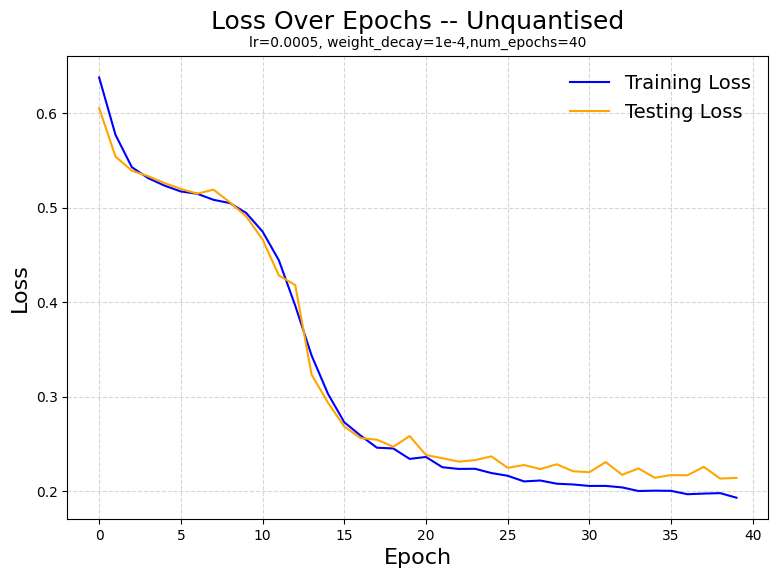

In [16]:
# plot the loss function
plot_loss(tr1, t1, subtitle="lr=0.0005, weight_decay=1e-4,num_epochs=40", model_name="Unquantised")

In [18]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [19]:
AUC(model1, test_loader)

AUC = 0.9661109057140573


In [26]:

model1.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs = model1(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
    
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9195833333333333
Predict time: 0.007632732391357422


In [27]:
lr = 0.0005
num_epochs = 40

In [17]:
model = BinaryClassificationModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        t.set_postfix(train_loss=loss.item())


100%|██████████| 40/40 [00:21<00:00,  1.85it/s, train_loss=0.198]


In [20]:

model.eval()
y_pre = []
T = []

for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
            print(times)
        T.append(times)
    
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

0.01950550079345703
0.020541667938232422
0.021352529525756836
0.022161483764648438
0.022823333740234375
0.02358841896057129
0.02432990074157715
0.0251312255859375
0.02600240707397461
0.026761531829833984
0.027522563934326172
0.028201818466186523
0.0008358955383300781
0.0015189647674560547
0.0023262500762939453
0.003117799758911133
0.0037827491760253906
0.004575014114379883
0.005133867263793945
0.005716085433959961
0.006455183029174805
0.007215261459350586
0.008117198944091797
0.008926630020141602
0.0007727146148681641
0.001291513442993164
0.0017817020416259766
0.002240419387817383
0.0028829574584960938
0.0033588409423828125
0.003814220428466797
0.004271984100341797
0.004737138748168945
0.005184650421142578
0.0057485103607177734
0.006148338317871094
0.0006122589111328125
0.0012392997741699219
0.0017809867858886719
0.0024080276489257812
0.003181934356689453
0.003867626190185547
0.004511594772338867
0.0051343441009521484
0.005709409713745117
0.006273031234741211
0.006826877593994141
0.007

(array([175.,  23.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00555301, 0.00781789, 0.01008277, 0.01234765, 0.01461253,
        0.01687741, 0.01914229, 0.02140718, 0.02367206, 0.02593694,
        0.02820182]),
 <BarContainer object of 10 artists>)

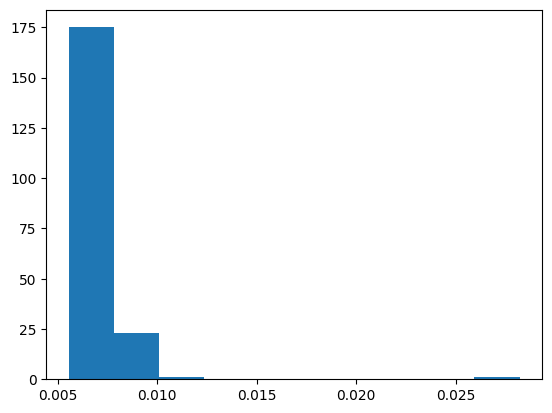

In [21]:
plt.hist(T)

In [30]:

model.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()
QT = []
for _ in range(200):
    correct = 0
    total = 0
    Qtimes = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            stt = time.time()
            outputs = quantized_model(inputs)
            ent = time.time()
            Qtimes+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    QT.append(Qtimes)
QT=np.array(QT)
accuracy2 = correct / total
print(f'Accuracy = {accuracy2}')
print(f'Predict time: {Qtimes}')

Accuracy = 0.89675
Predict time: 0.00788569450378418
